<a href="https://colab.research.google.com/github/ileoh/rioairbnb/blob/main/RioAirBnB_Cognitivoai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Teste Data Science - Cognitivo.ai

# Contexto
- O trabalho abaixo consiste em:
  - Leitura e visão geral dos dados
  - Pré processamento
    - Escolha das variáveis, limpeza dos preços, manipulação de missing e engenharia de atributos (feature engineering)
  - Análise Exploratória (EDA)
  - Modelagem (XGboost)
  - Resultados


## Importaçao dos dados e das bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('seaborn')
import seaborn as sns

import re
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df_initial = pd.read_csv('/content/drive/MyDrive/2021/Teste cognitivo ai/listings 2.csv')

# checking shape
print("O dataset possui {} linhas e {} colunas.".format(*df_initial.shape))

# ... and duplicates
print("Ele possui {} duplicados.".format(df_initial.duplicated().sum()))

O dataset possui 26615 linhas e 74 colunas.
Ele possui 0 duplicados.


In [4]:
df_initial.head(1)  # visao básica do dataset

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,17878,https://www.airbnb.com/rooms/17878,20210222161029,2021-02-23,"Very Nice 2Br in Copacabana w. balcony, fast WiFi",Discounts for long term stays. <br />- Large b...,This is the one of the bests spots in Rio. Bec...,https://a0.muscache.com/pictures/65320518/3069...,68997,https://www.airbnb.com/users/show/68997,Matthias,2010-01-08,"Rio de Janeiro, State of Rio de Janeiro, Brazil",I am a journalist/writer. Lived for 15 years...,within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/67b13...,https://a0.muscache.com/im/pictures/user/67b13...,Copacabana,2.0,2.0,"['email', 'phone', 'reviews', 'jumio', 'offlin...",t,t,"Rio de Janeiro, Brazil",Copacabana,NaN,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,NaN,1 bath,2.0,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",$221.00,5,180,5.0,5.0,1125.0,1125.0,5.0,1125.0,NaN,t,0,8,38,304,2021-02-23,260,12,2,2010-07-15,2021-02-08,94.0,9.0,9.0,10.0,10.0,10.0,9.0,NaN,t,1,1,0,0,2.01


In [5]:
# análise das colunas que temos
df_initial.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

## Pre-processamento de dados

- Escolha de variaveis adequadas

In [6]:
# definindo as variáveis que desejamos continuar
columns_to_keep = ['id', 'description', 'host_has_profile_pic', 'neighbourhood_group_cleansed', 
                   'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',  
                   'bedrooms', 'amenities', 'price', 
                      'minimum_nights',  
                   'instant_bookable']

df_raw = df_initial[columns_to_keep].set_index('id')
print("O dataset tem {} linhas e {} colunas - após dropar colunas irrelevantes.".format(*df_raw.shape))

O dataset tem 26615 linhas e 14 colunas - após dropar colunas irrelevantes.


- Estudando a base escolhida

In [7]:
df_raw.head()

,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,amenities,price,minimum_nights,instant_bookable
id,,,,,,,,,,,,,,
17878,Discounts for long term stays. <br />- Large b...,t,NaN,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,NaN,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",$221.00,5,t
24480,My studio is located in the best of Ipanema. ...,t,NaN,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,NaN,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",$307.00,3,f
25026,"Our apartment is a little gem, everyone loves ...",t,NaN,-22.97712,-43.19045,Entire apartment,Entire home/apt,2,NaN,1.0,"[""Elevator"", ""Dedicated workspace"", ""Kitchen"",...",$160.00,7,f
35636,This cosy apartment is just a few steps away ...,t,NaN,-22.98816,-43.19359,Entire apartment,Entire home/apt,2,NaN,1.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",$273.00,2,f
35764,Our newly renovated studio is located in the b...,t,NaN,-22.98127,-43.19046,Entire loft,Entire home/apt,2,NaN,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",$135.00,3,f


In [8]:
# Quantos tipos de local temos
df_raw.room_type.value_counts(normalize=True)

Entire home/apt    0.724591
Private room       0.248694
Shared room        0.022995
Hotel room         0.003720
Name: room_type, dtype: float64

In [9]:
# Quantos tipos de propriedades temos
df_raw.property_type.value_counts(normalize=True)

Entire apartment               0.576893
Private room in apartment      0.155852
Entire condominium             0.047342
Private room in house          0.046402
Entire house                   0.042908
                                 ...   
Private room in boat           0.000038
Entire hostel                  0.000038
Shared room in nature lodge    0.000038
Private room in tent           0.000038
Shared room in townhouse       0.000038
Name: property_type, Length: 87, dtype: float64

### Limpeza da coluna de preços

In [10]:
df_raw[['price']].head(3)

,price
id,
17878,$221.00
24480,$307.00
25026,$160.00


In [12]:
# Verificando os Nan's na coluna de preço
df_raw.price.isna().sum()

0

- Remover o sinal de dolar da coluna

In [13]:
# Limpando a coluna
df_raw.price = df_raw.price.str.replace('$', '').str.replace(',', '').astype(float)

In [14]:
df_raw.head()

,description,host_has_profile_pic,neighbourhood_group_cleansed,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,amenities,price,minimum_nights,instant_bookable
id,,,,,,,,,,,,,,
17878,Discounts for long term stays. <br />- Large b...,t,NaN,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,NaN,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",221.0,5,t
24480,My studio is located in the best of Ipanema. ...,t,NaN,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,NaN,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",307.0,3,f
25026,"Our apartment is a little gem, everyone loves ...",t,NaN,-22.97712,-43.19045,Entire apartment,Entire home/apt,2,NaN,1.0,"[""Elevator"", ""Dedicated workspace"", ""Kitchen"",...",160.0,7,f
35636,This cosy apartment is just a few steps away ...,t,NaN,-22.98816,-43.19359,Entire apartment,Entire home/apt,2,NaN,1.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",273.0,2,f
35764,Our newly renovated studio is located in the b...,t,NaN,-22.98127,-43.19046,Entire loft,Entire home/apt,2,NaN,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",135.0,3,f


- Verificando agora o preço, para ver a necessidade de limpeza

In [16]:
df_raw['price'].describe()

count     26615.000000
mean        742.589254
std        5368.868834
min           0.000000
25%         157.000000
50%         280.000000
75%         550.000000
max      625216.000000
Name: price, dtype: float64

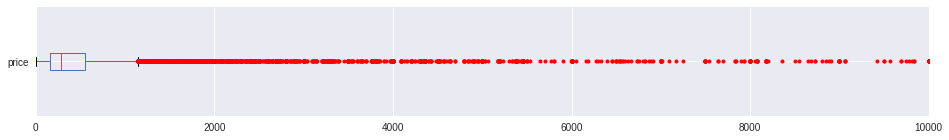

In [17]:
red_square = dict(markerfacecolor='r', markeredgecolor='r', marker='.')
df_raw['price'].plot(kind='box', xlim=(0, 10000), vert=False, flierprops=red_square, figsize=(16,2));

Temos a média em 742, porém o máximo é de 625216
Vamos fazer uma limpeza básica e limitar os valores em 4000, onde os outliers 
parecem estar mais espaçados

In [18]:
df_raw.drop(df_raw[ (df_raw.price > 4000) | (df_raw.price == 0) ].index, axis=0, inplace=True)

In [19]:
df_raw['price'].describe()


count    26123.000000
mean       466.545075
std        542.664198
min         33.000000
25%        153.000000
50%        276.000000
75%        530.000000
max       4000.000000
Name: price, dtype: float64

In [21]:
print("O dataset possui {} linhas e {} colunas - após o preprocessamento do preço.".format(*df_raw.shape))

O dataset possui 26123 linhas e 14 colunas - após o preprocessamento do preço.


### Lidando com valores ausentes

In [22]:
df_raw.isna().sum()

description                      1430
host_has_profile_pic               22
neighbourhood_group_cleansed    26123
latitude                            0
longitude                           0
property_type                       0
room_type                           0
accommodates                        0
bathrooms                       26123
bedrooms                         1726
amenities                           0
price                               0
minimum_nights                      0
instant_bookable                    0
dtype: int64

In [23]:
# removendo as colunas com muitos NA's
df_raw.drop(columns=['bathrooms', 'neighbourhood_group_cleansed'], inplace=True)

In [24]:
# removendo as linhas com Nan's em bedrooms
df_raw.dropna(subset=[ 'bedrooms', ], inplace=True)

In [25]:
df_raw.host_has_profile_pic.unique()  

array(['t', 'f', nan], dtype=object)

In [26]:
# substituindo host_has_profile_pic Nan's com nao
df_raw.host_has_profile_pic.fillna(value='f', inplace=True)
df_raw.host_has_profile_pic.unique()

array(['t', 'f'], dtype=object)

In [27]:
df_raw.isna().sum()

description             1246
host_has_profile_pic       0
latitude                   0
longitude                  0
property_type              0
room_type                  0
accommodates               0
bedrooms                   0
amenities                  0
price                      0
minimum_nights             0
instant_bookable           0
dtype: int64

In [28]:
print("O dataset tem {} linhas e {} colunas - apos lidar com os valores faltantes.".format(*df_raw.shape))

O dataset tem 24397 linhas e 12 colunas - apos lidar com os valores faltantes.


## Engenharia de atributos - Feature Engineering

### Feature Engineering 1: Distancia do centro do Rio



In [29]:
from geopy.distance import great_circle

In [30]:
def distance_to_mid(lat, lon):
    rio_center = (-22.906847, -43.172897)  # localizaçao do centro do Rio
    accommodation = (lat, lon)
    return great_circle(rio_center, accommodation).km

In [31]:
df_raw['distance'] = df_raw.apply(lambda x: distance_to_mid(x.latitude, x.longitude), axis=1)

In [32]:
df_raw.head(2)

,description,host_has_profile_pic,latitude,longitude,property_type,room_type,accommodates,bedrooms,amenities,price,minimum_nights,instant_bookable,distance
id,,,,,,,,,,,,,
17878,Discounts for long term stays. <br />- Large b...,t,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,2.0,"[""Air conditioning"", ""Essentials"", ""Luggage dr...",221.0,5,t,6.597905
24480,My studio is located in the best of Ipanema. ...,t,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,1.0,"[""Extra pillows and blankets"", ""Air conditioni...",307.0,3,f,9.258345


### Feature Engineering 3: Amenities



Contexto: 
A palavra ainda é pouco conhecida, mas os amenities são os cosméticos disponibilizados para os hóspedes nos hotéis. São itens obrigatórios, como sabonetes e xampus, oferecidos por todos os tipos de hospedagens. No entanto, de um tempo para cá os hoteleiros estão percebendo o potencial destes produtos como atrativos.

Os amenities podem ser verdadeiros diferenciais para os hotéis. Diversas redes têm investido pesado em produtos especiais, com fragrâncias, embalagens, além da própria diversificação da linha. Os produtos deixaram de ser apenas pequenos sabonetes e mini-frascos de xampu. Agora os hoteleiros investem em óleos essenciais, sais de banho, loções de limpeza, hidratantes, entre outros.
fonte: https://www.cpt.com.br/noticias/amenities-podem-ser-diferencial-em-hoteis

In [34]:
from collections import Counter

In [35]:
results = Counter()
df_raw['amenities'].str.strip('{}')\
               .str.replace('"', '')\
               .str.lstrip('\"')\
               .str.rstrip('\"')\
               .str.split(',')\
               .apply(results.update)

results.most_common(30)

[(' Wifi', 21433),
 (' Long term stays allowed', 20422),
 (' Essentials', 20344),
 (' Kitchen', 20008),
 (' TV', 19400),
 (' Air conditioning', 16084),
 (' Iron', 15916),
 (' Hangers', 15575),
 (' Washer', 15433),
 (' Hot water', 13903),
 (' Dedicated workspace', 11930),
 (' Dishes and silverware', 11525),
 (' Refrigerator', 10415),
 (' Microwave', 9769),
 (' Cooking basics', 9564),
 (' Hair dryer', 9356),
 (' Bed linens', 9027),
 (' Stove', 8862),
 (' Elevator', 8084),
 ('[Elevator', 6953),
 (' Coffee maker', 6937),
 (' Free parking on premises', 6756),
 (' Oven', 6700),
 (' Pool', 6413),
 (' Cable TV', 5718),
 (' Luggage dropoff allowed', 5178),
 (' Shampoo', 5026),
 (' Private entrance', 4708),
 (' Fire extinguisher]', 4442),
 ('[Extra pillows and blankets', 4419)]

In [36]:
# criando um novo dataframe
sub_df = pd.DataFrame(results.most_common(30), columns=['amenity', 'count'])

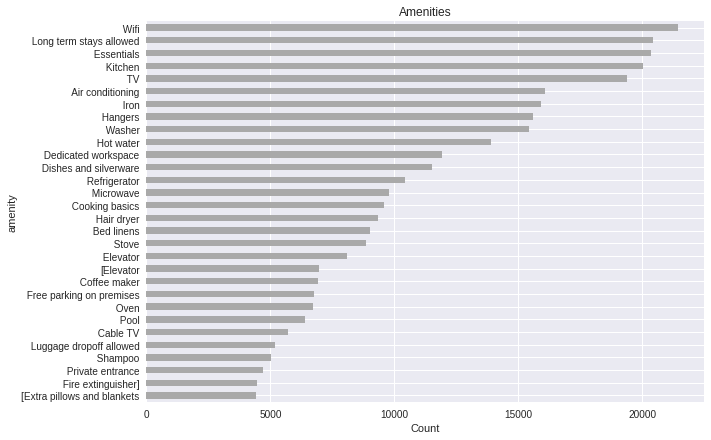

In [37]:
# plot the Top 20
sub_df.sort_values(by=['count'], ascending=True).plot(kind='barh', x='amenity', y='count',  
                                                      figsize=(10,7), legend=False, color='darkgrey',
                                                      title='Amenities')
plt.xlabel('Count');

Vamos adicionar colunas com comodidades que são um tanto únicas e não oferecidas por todos os hosts:

- TV
- Hot Water
- Dedicated workspace
- Cooking basics
- Hair dryer

In [38]:
df_raw['Hot water'] = df_raw['amenities'].str.contains('Hot water')
df_raw['TV'] = df_raw['amenities'].str.contains('TV')
df_raw['Dedicated workspace'] = df_raw['amenities'].str.contains('Dedicated workspace')
df_raw['Cooking basics'] = df_raw['amenities'].str.contains('Cooking basics')
df_raw['Hair dryer'] = df_raw['amenities'].str.contains('Hair dryer')

In [39]:
df_raw.drop(['amenities'], axis=1, inplace=True)

## Análise Exploratória de Dados (EDA)

In [40]:
df = df_raw.copy()

In [41]:
df.head()

,description,host_has_profile_pic,latitude,longitude,property_type,room_type,accommodates,bedrooms,price,minimum_nights,instant_bookable,distance,Hot water,TV,Dedicated workspace,Cooking basics,Hair dryer
id,,,,,,,,,,,,,,,,,
17878,Discounts for long term stays. <br />- Large b...,t,-22.96592,-43.17896,Entire condominium,Entire home/apt,5,2.0,221.0,5,t,6.597905,True,True,True,True,True
24480,My studio is located in the best of Ipanema. ...,t,-22.98570,-43.20193,Entire apartment,Entire home/apt,2,1.0,307.0,3,f,9.258345,True,True,True,False,True
25026,"Our apartment is a little gem, everyone loves ...",t,-22.97712,-43.19045,Entire apartment,Entire home/apt,2,1.0,160.0,7,f,8.018073,False,True,True,False,True
35636,This cosy apartment is just a few steps away ...,t,-22.98816,-43.19359,Entire apartment,Entire home/apt,2,1.0,273.0,2,f,9.286562,True,True,False,True,True
35764,Our newly renovated studio is located in the b...,t,-22.98127,-43.19046,Entire loft,Entire home/apt,2,1.0,135.0,3,f,8.468632,True,True,True,True,True


- Diferença de preço no mapa


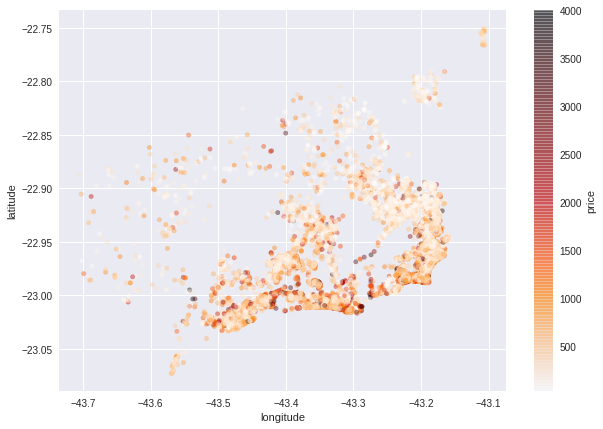

In [42]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4, figsize=(10,7), 
        c="price", cmap="gist_heat_r", colorbar=True, sharex=False);

- Diferenças de preços por distância de acomodação até o centro do Rio

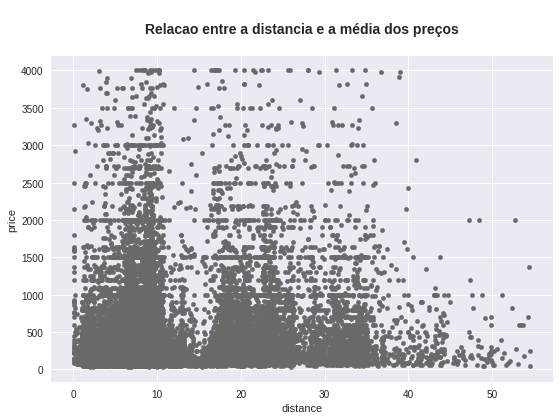

In [45]:
df.plot.scatter(x="distance", y="price", figsize=(9,6), c='dimgrey')
plt.title('\nRelacao entre a distancia e a média dos preços\n', fontsize=14, fontweight='bold');

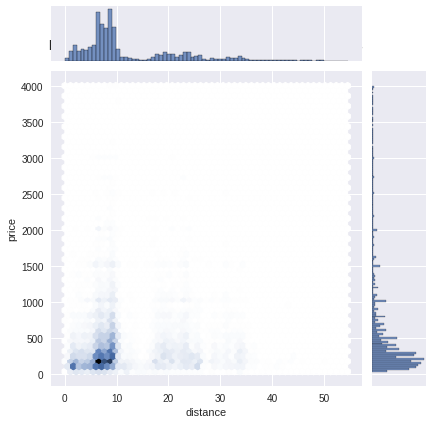

In [46]:
sns.jointplot(x=df["distance"], y=df["price"], kind='hex')
plt.title('\nRelacao entre a distancia e a média dos precos\n', fontsize=14, fontweight='bold');


## Modelagem

### Preparando o target e as features



In [47]:
df.columns

Index(['description', 'host_has_profile_pic', 'latitude', 'longitude',
       'property_type', 'room_type', 'accommodates', 'bedrooms', 'price',
       'minimum_nights', 'instant_bookable', 'distance', 'Hot water', 'TV',
       'Dedicated workspace', 'Cooking basics', 'Hair dryer'],
      dtype='object')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24397 entries, 17878 to 48276004
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   description           23151 non-null  object 
 1   host_has_profile_pic  24397 non-null  object 
 2   latitude              24397 non-null  float64
 3   longitude             24397 non-null  float64
 4   property_type         24397 non-null  object 
 5   room_type             24397 non-null  object 
 6   accommodates          24397 non-null  int64  
 7   bedrooms              24397 non-null  float64
 8   price                 24397 non-null  float64
 9   minimum_nights        24397 non-null  int64  
 10  instant_bookable      24397 non-null  object 
 11  distance              24397 non-null  float64
 12  Hot water             24397 non-null  bool   
 13  TV                    24397 non-null  bool   
 14  Dedicated workspace   24397 non-null  bool   
 15  Cooking basi

- Como trabalhamos com a distancia até o centro, vamos remover algumas colunas desnecessárias

In [49]:
df.drop(['latitude', 'longitude', 'property_type'], axis=1, inplace=True)

- Convertendo as colunas de strings em categorias

In [50]:
for col in ['host_has_profile_pic', 'room_type', 'instant_bookable']:
    df[col] = df[col].astype('category')

In [51]:
# definindo o target
target = df[["price"]]

# definindo as features
features = df.drop(["price"], axis=1)

- One Hot Encoding

In [52]:
num_feats = features.select_dtypes(include=['float64', 'int64', 'bool']).copy()

# one-hot encoding para features categoricas 
cat_feats = features.select_dtypes(include=['category']).copy()
cat_feats = pd.get_dummies(cat_feats)

In [53]:
features_recoded = pd.concat([num_feats, cat_feats], axis=1)

In [54]:
print(features_recoded.shape)
features_recoded.head(2)

(24397, 17)


,accommodates,bedrooms,minimum_nights,distance,Hot water,TV,Dedicated workspace,Cooking basics,Hair dryer,host_has_profile_pic_f,host_has_profile_pic_t,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,instant_bookable_f,instant_bookable_t
id,,,,,,,,,,,,,,,,,
17878,5,2.0,5,6.597905,True,True,True,True,True,0,1,1,0,0,0,0,1
24480,2,1.0,3,9.258345,True,True,True,False,True,0,1,1,0,0,0,1,0


#### Splitting e Scaling dos dados

In [55]:
# import train_test_split function
from sklearn.model_selection import train_test_split
# import metrics
from sklearn.metrics import mean_squared_error, r2_score

# split dos dados
X_train, X_test, y_train, y_test = train_test_split(features_recoded, target, test_size=0.2)

In [56]:
# scale data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test  = sc.transform(X_test)

In [57]:
X_train

array([[ 4.86114213,  5.39680216, -0.19182906, ..., -0.16014078,
         0.72030041, -0.72030041],
       [-0.88604108, -0.677557  , -0.19182906, ..., -0.16014078,
         0.72030041, -0.72030041],
       [ 0.75601126,  1.34722939, -0.08896966, ..., -0.16014078,
        -1.38830963,  1.38830963],
       ...,
       [-0.06501491, -0.677557  , -0.19182906, ..., -0.16014078,
        -1.38830963,  1.38830963],
       [-0.06501491, -0.677557  ,  0.01388973, ..., -0.16014078,
         0.72030041, -0.72030041],
       [ 0.34549818,  0.3348362 ,  0.11674913, ..., -0.16014078,
        -1.38830963,  1.38830963]])

In [58]:
X_test

array([[-0.88604108, -0.677557  , -0.08896966, ..., -0.16014078,
         0.72030041, -0.72030041],
       [-1.29655417, -0.677557  , -0.19182906, ..., -0.16014078,
         0.72030041, -0.72030041],
       [-0.88604108, -0.677557  , -0.19182906, ..., -0.16014078,
         0.72030041, -0.72030041],
       ...,
       [-0.88604108, -0.677557  , -0.19182906, ..., -0.16014078,
         0.72030041, -0.72030041],
       [-0.88604108, -0.677557  , -0.14039936, ..., -0.16014078,
         0.72030041, -0.72030041],
       [ 3.21908978,  1.34722939,  0.01388973, ..., -0.16014078,
        -1.38830963,  1.38830963]])

### Treinando um regressor XGBoost



In [69]:
# create a baseline
booster = xgb.XGBRegressor()

In [70]:
from sklearn.model_selection import GridSearchCV

# create Grid
param_grid = {'n_estimators': [100, 150, 200],
              'learning_rate': [0.01, 0.05, 0.1], 
              'max_depth': [3, 4, 5, 6, 7],
              'colsample_bytree': [0.6, 0.7, 1],
              'gamma': [0.0, 0.1, 0.2]}

# instantiate the tuned random forest
booster_grid_search = GridSearchCV(booster, param_grid, cv=3, n_jobs=-1)

# train the tuned random forest
booster_grid_search.fit(X_train, y_train)

# print best estimator parameters found during the grid search
print(booster_grid_search.best_params_)

[09:09:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bytree': 0.6, 'gamma': 0.0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100}


In [83]:
# instantiate xgboost with best parameters
booster = xgb.XGBRegressor(colsample_bytree=0.6, gamma=0.2, learning_rate=0.05, 
                           max_depth=7, n_estimators=200, random_state=4)    

# train
booster.fit(X_train, y_train)

# predict
y_pred_train = booster.predict(X_train)
y_pred_test = booster.predict(X_test)

[09:20:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [84]:
RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE: {round(RMSE, 4)}")

RMSE: 427.6043


In [85]:
r2 = r2_score(y_test, y_pred_test)
r2
print(f"r2: {round(r2, 4)}")

r2: 0.4145


### Cross Validation



In [86]:
xg_train = xgb.DMatrix(data=X_train, label=y_train)

In [87]:
params = {'colsample_bytree':0.6, 'gamma':0.2, 'learning_rate':0.05, 'max_depth':6}

cv_results = xgb.cv(dtrain=xg_train, params=params, nfold=3,
                    num_boost_round=200, early_stopping_rounds=10, 
                    metrics="rmse", as_pandas=True)

In [88]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,709.046082,3.227810,709.115804,6.724010
1,688.152771,2.766509,688.473836,6.749577
2,669.157166,2.934801,669.640869,6.677341
3,650.862040,3.214903,651.658223,6.150206
4,635.205688,3.934146,636.414022,5.831232


In [89]:
cv_results.tail()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
136,386.397339,1.127303,432.509349,5.184581
137,386.213318,1.168311,432.505799,5.194303
138,386.143494,1.179209,432.528168,5.191531
139,386.038727,1.217688,432.511902,5.209537
140,385.726471,1.215932,432.500478,5.190089


### Interpretaçao dos resultados

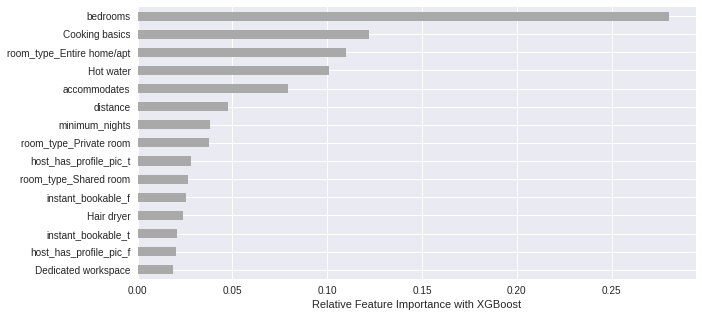

In [78]:
# plot the important features
feat_importances = pd.Series(booster.feature_importances_, index=features_recoded.columns)
feat_importances.nlargest(15).sort_values().plot(kind='barh', color='darkgrey', figsize=(10,5))
plt.xlabel('Relative Feature Importance with XGBoost');